# COGS 108 - Final Project 

# Overview

For this project we wanted to focus on police stops related with intoxicating substances (drugs and alcohol) and physical altercations. A large portion of our project outside the analysis was computing distances between these types of police stops and types of businesses. For our analysis we used  exploratory data analysis and the statistical modeling method ANOVA(analysis of variance) which is an extension of the independent T test. We used these methods to compare the average number of police stops within a specific radius from the business and defined this radius to be 500 meters which we believed was close to one blocks. 

# Names

- Les Wang
- Sebastian Troncoso
- Tamuz Hod
- Josh Freilich
- Baizhou Xu

# Group Members IDs

- A12985002
- A14217903
- A15230380
- A13837230
- U08254404

# Research Question

Our research question is "How does the type of business affect the type of police stops around different business types?". For our first analysis, the effect of the business is measured by determining the three closest stops that occur at the business. These three stops are considered to be directly influenced by the type of business in this analysis. The three closest stops were chosen in order to prevent variability and outliers as well as providing a larger picture for each business type. For our second analysis, the measure of how much a business affects the type of police stops is defined by the number of police stops that occur within a 0.5km radius (Note: the distance can be changed within the code to determine the correlation at different distances). 0.5km was chosen due to 0.5km being about the size of one block.

## Background and Prior Work

Through an interactive map provided by the San Diego Union Tribune, we searched for battery, alcohol, drug related crimes as they were the most frequent crimes reported <b>(1)</b>. We found that these three crimes had a strong connection to particular communities, such as Pacific Beach, Downtown San Diego, and Hillcrest. We wanted to investigate why there were high concentration of crime reports in this community, and found a l 2014 report from the University of Virginia explaining how pawn shops encouraged theft-related crimes. According to the report, experts explained that pawn shops in the premises increases the likelihood for a theft-related crime in the community since people in poverty see pawn shops as stores that help facilitate a market for stolen items <b>(2)</b>.  Police authorities have noticed the trend and began to work closely with pawns shop owners to arrest criminals selling stolen goods.

In fact, the more we searched location-crime related reports, the more we began to question whether or not businesses could attract crimes into the community. Our curiosity led us to a study done by the Center of Disease and Control Prevention which investigated tobacco and alcohol shops indirectly promoting crime in the Los Angeles area. According to the report, South Central Los Angeles had a significant amount of violent and property crime within a measured distance from these types of businesses <b>(3)</b>. Furthermore, another report performed in the Sacramento area explained that residents living close by alcohol stores had a stronger tendency to return back to purchase more alcohol, which led those individuals become arrested due public intoxications and disruptive behavior <b>(4)</b>.
 For this project, we decided to investigate battery and alcohol related crimes due to the frequency of reported cases, and research possible types of businesses attracting  these crime in the San Diego area.

References:
- 1) San Diego Historical Crime Actuals
https://www.sandiego.gov/sites/default/files/ucr1950to2018.pdf
- 2)“Interactive Map of Crimes in San Diego”
https://www.sandiegouniontribune.com/news/public-safety/story/2019-06-05/interactive-map-shows-crimes-around-san-diego-20190604
- 3)“Type of business attracting crime - Pawn Shops and Marijuana Stores”
https://archive.attn.com/stories/3382/which-businesses-attract-crime
- 4)“Tobacco and Alcohol promote violent and property crime”
https://www.sciencedirect.com/science/article/pii/S0091743517305078
- 5)“Sacramento police officers”
http://www.colgate.edu/portaldata/imagegallerywww/2050/ImageGallery/teh_jobmktpaper.pdf



# Hypothesis


From our background research we predict that a correlation exists between stops relating to alcohol, drugs, and physical altercations and the type of business. We believe this outcome will be correct based on previous research done on the correlation of alcohol and arrests. For example, we believe that police tend to frequent areas that have a larger number of potentially dangerous conflicts, which are frequent at businesses that provide alcohol as seen above in our research. Because more police activity exists in these areas, the likelihood of being stopped by police in these areas are higher. 

# Dataset(s)

<b>Dataset: Ripa police stop data - reason for stop</b>
- Link: https://data.sandiego.gov/datasets/police-ripa-stop-reason/
- Number of observations: 91962
- Description: The data collection of San Diego Police Stops was due to the Racial and Identity Profiling Act of 2015 or RIPA. The dataset contains information on the reason for the police stop as well as to the information for each stop. This is further broken down into stop_id and pid, indicating each stop and each person uniquely per stop (as there can be multiple people involved in a single stop).

<b>Dataset: Ripa police stop data - stop details</b>
- Link: https://data.sandiego.gov/datasets/police-ripa-stop-reason/
- Number of observations: 89485
- Description: The data collection of San Diego Police Stops was due to the Racial and Identity Profiling Act of 2015 or RIPA. The dataset contains information on multiple aspects of the stop, but in regards to this project, mainly stop location. The datasets also included the same pid and stop_id used above in the Ripa police stop data - reason for stop. 

<b> Note about number of observations of RIPA datasets: </b> After data cleaning, and only using our desired types of crimes, the total number of crime (combining RIPA datasets) data points is 2597.

<b>Dataset: San Diego Department of Treasury’s Active Business Listings</b>
- Link: https://www.sandiego.gov/treasurer/taxesfees/btax/nblactive
- Number of observations: 39195 After data cleaning, the number of observations for this dataset is 26058 (See Data Cleaning section for more detailed information).
- Description: This dataset contains information on all businesses who have registered for a City of San Diego Business Tax Certificate. For this project, we mainly looked at business activity and location. We further condensed the business activities to more general labels. This was done in order to make each business activity have enough data points to make significant analysis. 
- <b>Note: </b>This dataset was the combination of two datasets as they were split alphabetically between A - K and L - Z but they will be considered one dataset as they contain the 



<b>Note on how RIPA Datasets were used together: </b>
Each of the RIPA datasets contained pid and stop_id columns. These columns were concatenated together with an underscore in between to create a unique identifier, named “uid”, which was used to merge the two RIPA datasets. 

<b>Note on how RIPA Datasets and Business Datasets were used together: </b>
	We found the latitude and longitude data of the crime committed from its location metadata. Using the latitude and longitude data of the crime, we researched whether or not there was a correlation between the type of business, labeled “ACTIVITY DESC” in the business dataset, and the frequency of nearby crimes.


# Setup

In [48]:
# Imports needed for the code to run 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import geopy.distance
import sklearn
from statsmodels.formula.api import ols


from sklearn.neighbors import kneighbors_graph
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, precision_recall_fscore_support

# Data Cleaning

In this step the datasets are imported and a universal identifier (uid) is created from the stop_id and pid columns.

In [2]:
# Creating data tables from the RIPA datasets
reason_df = pd.read_csv("Datasets/reason_for_stop.csv")
details_df = pd.read_csv("Datasets/basic_details.csv",low_memory=False)

# Adding a unique identifier column to combine the stop_id and pid (person id) 
# This is done to be able to combine the two RIPA datasets into one
reason_df['uid'] = reason_df.stop_id.astype(str).str.cat(reason_df.pid.astype(str), sep='_')
details_df['uid'] = details_df.stop_id.astype(str).str.cat(details_df.pid.astype(str), sep='_')



Next the datasets are merged on the <b>uid</b> and all columns that are not relevant to this analysis are dropped.

In [3]:
# Merging two RIPA datasets into one based on uid
totalStop_df = pd.merge(reason_df, details_df, on='uid')

# Dropping unused columns from dataset
totalStop_df = totalStop_df.drop(["agency", "beat", "beat_name", "isschool","school_name", "isstudent"], axis=1)

To create the business dataframe, we simply concatenated the two business csv files that were separated in to (A-L) and (L-Z)

In [ ]:
# Combining two dataframes that comprise businesss from A-L and L-Z
dfA_L = pd.read_csv('Data/tr_active1.csv')
dfL_Z = pd.read_csv('Data/tr_active2.csv')
df_business = pd.concat([dfA_L,dfL_Z])

###### This section will focus on how we extracted the address information from this df and the use of the US cencus georecorder tool.


Step 1)
Get the address infromation from the data sets so it can be used in the US census geocoder tool.

The US census geocoder is accepts csv sheets of up to 10,000 lines where each line is formated in the follwing way:
"street number street name, City, State, " 
ex:
"4800 NIAGARA AVE, SAN DIEGO, CA,"

In [4]:
df_business.head()

,BUSINESS ACCT#,DBA NAME,OWNERSHIP TYPE,ADDRESS,CITY,ZIP,STATE,BUSINESS PHONE,OWNER NAME,CREATION DT,START DT,EXP DT,NAICS,ACTIVITY DESC
0,1981012901,#1 FIFTH AVENUE,CORP,3845 05TH AVE,SAN DIEGO,92103-3140,CA,NaN,PUBWAY CORP,12/09/1981,12/09/1981,11/30/2019,722,FOOD SERVICES & DRINKING PLACES
1,2019005727,#WHO DO U THINK U ARE,SOLE,5754 ELK ST,SAN DIEGO,92114-4025,CA,(619) 362-0605,KIESHA MILLER,04/02/2019,04/08/2019,04/30/2020,5141,INFORMATION SERVICES
2,2010034224,% NATURAL GOMEZ,SOLE,4356 POPLAR ST,SAN DIEGO,92105-4657,CA,(619) 417-0105,JUANA GOMEZ,11/12/2010,11/12/2010,11/30/2019,446199,ALL OTHER HEALTH & PERSONAL CARE STORES
3,2015046247,& SALLY J FERNANDEZ,SOLE,17471 PLAZA CERADO SUITE 98,SAN DIEGO,92128-2285,CA,NaN,JAIME V FERNANDEZ,10/29/2015,01/01/2014,12/31/2019,541219,OTHER ACCOUNTING SERVICES
4,2007016185,+A PARTNERS,CORP,3916 NORMAL ST,SAN DIEGO,92103-3413,CA,(619) 294-4477,+A PARTNERS,07/11/2007,07/01/2004,06/30/2019,531,REAL ESTATE


We discovered that the CITY coulmn was "SAN DIEGO" even when address were located in "La Jolla" or "El Cajon"
So we tried each address for both of these city names as well 

In [5]:
# Gets the location metadata from the business dataset and formats it
def generateCSVadresses() :
    for j in range(0,18):
        f = open("business_loc"+str(j)+".csv","w+")
        print(j)
        for i in range(3333*j, 3333 * (j+1)):
            if(i >= len(df_business) -1):
                break
            row = df_business.iloc[i]
            try:
                f.write(str(i) + '001,' + row['ADDRESS'] + ',' + row['CITY'] + ',CA,\n')
                if(row['CITY'] == "SAN DIEGO") : 
                    f.write(str(i) + '002,' + row['ADDRESS'] + ',' + 'La Jolla' + ',CA,\n')
                    f.write(str(i) + '003,' + row['ADDRESS'] + ',' + 'El Cajon' + ',CA,\n')
            except:
                print("Error on line ", i)
        f.close()
# generateCSVadresses()

We then manually inputted this into the georecorder (https://geocoding.geo.census.gov/geocoder/locations/addressbatch?form)
as this was to be done only once.

We than combined the csv files using the command line and uploaded the result to our data folder

In [6]:
# Input
data_file = "Data/GeoBusinessData/geoBusinessData.csv"

# Generate column names
column_names = ['uid', 'address', 'match?', 'exact?', 'full_address', 'lon,lat', 'remove', 'LR']
geoBusiness_df = pd.read_csv(data_file, header=None, names=column_names)
geoBusiness_df.count()

uid             170370
address         170370
match?          170370
exact?           51353
full_address     51353
lon,lat          51353
remove           51353
LR               51353
dtype: int64

We procceded to drop any row that was not a match
and get back the orginal index location

In [7]:
geoBusiness_df = geoBusiness_df.dropna()

#Remove previous formatting in order to obtain original uid
def shorten(uid) :
    return int(str(uid)[0:len(str(uid)) - 3])
geoBusiness_df['uid'] = geoBusiness_df['uid'].apply(shorten)

geoBusiness_df = geoBusiness_df.set_index('uid')
geoBusiness_df = geoBusiness_df.sort_index()
geoBusiness_df.head()

,address,match?,exact?,full_address,"lon,lat",remove,LR
uid,,,,,,,
1,"5754 ELK ST, SAN DIEGO, CA,",Match,Exact,"5754 ELK ST, SAN DIEGO, CA, 92114","-117.07374,32.704464",648577820.0,L
2,"4356 POPLAR ST, SAN DIEGO, CA,",Match,Exact,"4356 POPLAR ST, SAN DIEGO, CA, 92105","-117.10183,32.737766",195347398.0,L
3,"17471 PLAZA CERADO SUITE 98, SAN DIEGO, CA,",Match,Non_Exact,"17471 PLZ CERADO, SAN DIEGO, CA, 92128","-117.05527,33.028744",612877365.0,R
4,"3916 NORMAL ST, SAN DIEGO, CA,",Match,Exact,"3916 NORMAL ST, SAN DIEGO, CA, 92103","-117.14946,32.749218",195342882.0,L
5,"5383 AUBURN DR, SAN DIEGO, CA,",Match,Exact,"5383 AUBURN DR, SAN DIEGO, CA, 92105","-117.089806,32.73843",195350513.0,R


Since we got the addresses from a concatenated dataframe of the business A_L and L_Z we had to match the index the folowing way:

In [8]:
dfA_L["lon"] = np.nan
dfA_L["lat"] = np.nan
dfL_Z["lon"] = np.nan
dfL_Z["lat"] = np.nan

In [9]:
#Corresponds location data to original business
for i in range (0,len(dfA_L)) :
    try :
        loc_lat = geoBusiness_df.loc[i,:]["lon,lat"]
        dfA_L.iat[i, len(dfA_L.columns) - 2] = loc_lat[0:loc_lat.find(',')]
        dfA_L.iat[i, len(dfA_L.columns) - 1] = loc_lat[loc_lat.find(',')+1:]
    except :
        continue

for i in range (0,len(dfL_Z)) :
    try :
        loc_lat = geoBusiness_df.loc[28302 + i,:]["lon,lat"]
        dfL_Z.iat[i, len(dfL_Z.columns) - 2] = loc_lat[0:loc_lat.find(',')]
        dfL_Z.iat[i, len(dfL_Z.columns) - 1] = loc_lat[loc_lat.find(',')+1:]
    except :
        continue

We than got rid of the businesses from whom we did not find an address and recombined them

In [10]:
dfA_L.dropna(inplace = True)
dfL_Z.dropna(inplace = True)

business_df = pd.concat([dfA_L, dfL_Z]).reset_index(drop=True)
business_df.head()

,BUSINESS ACCT#,DBA NAME,OWNERSHIP TYPE,ADDRESS,CITY,ZIP,STATE,BUSINESS PHONE,OWNER NAME,CREATION DT,START DT,EXP DT,NAICS,ACTIVITY DESC,lon,lat
0,2019005727,#WHO DO U THINK U ARE,SOLE,5754 ELK ST,SAN DIEGO,92114-4025,CA,(619) 362-0605,KIESHA MILLER,04/02/2019,04/08/2019,04/30/2020,5141,INFORMATION SERVICES,-117.073740,32.704464
1,2010034224,% NATURAL GOMEZ,SOLE,4356 POPLAR ST,SAN DIEGO,92105-4657,CA,(619) 417-0105,JUANA GOMEZ,11/12/2010,11/12/2010,11/30/2019,446199,ALL OTHER HEALTH & PERSONAL CARE STORES,-117.101830,32.737766
2,2007016185,+A PARTNERS,CORP,3916 NORMAL ST,SAN DIEGO,92103-3413,CA,(619) 294-4477,+A PARTNERS,07/11/2007,07/01/2004,06/30/2019,531,REAL ESTATE,-117.149460,32.749218
3,2016012911,1 ALL EYES AND EARS,SOLE,5383 AUBURN DR,SAN DIEGO,92105-3624,CA,(619) 395-1586,KATRINA GONZALEZ,09/26/2016,10/01/2016,09/30/2019,62419,OTHER INDIVIDUAL & FAMILY SERVICES,-117.089806,32.738430
4,2013047218,1 AMERICAN LIVESCAN,CORP,3690 MURPHY CANYON RD SUITE 102,SAN DIEGO,92123-4455,CA,(858) 874-3119,STONECREST GAS & WASH INC,04/30/2013,01/01/2012,12/31/2019,561611,INVESTIGATION SERVICES,-117.116520,32.809334


Finally we got rid of everything that was not business type and the location data

In [11]:
business_df = business_df[["ACTIVITY DESC", "lon", "lat"]]
business_df.head()

,ACTIVITY DESC,lon,lat
0,INFORMATION SERVICES,-117.073740,32.704464
1,ALL OTHER HEALTH & PERSONAL CARE STORES,-117.101830,32.737766
2,REAL ESTATE,-117.149460,32.749218
3,OTHER INDIVIDUAL & FAMILY SERVICES,-117.089806,32.738430
4,INVESTIGATION SERVICES,-117.116520,32.809334


The same process was done to the police stop data

In [12]:
data_file = "Data/GeoCrimeData/reasonable_loc_result.csv"
column_names = ['uid', 'address', 'match?', 'exact?', 'full_address', 'lon,lat', 'remove', 'remove']
geoCrime_reasonable_df = pd.read_csv(data_file, header=None, names=column_names)

geoCrime_reasonable_df = geoCrime_reasonable_df.dropna()
geoCrime_reasonable_df['uid'] = geoCrime_reasonable_df['uid'].apply(shorten)

geoCrime_reasonable_df = geoCrime_reasonable_df.set_index('uid')
geoCrime_reasonable_df = geoCrime_reasonable_df.sort_index()

df_reasonable = pd.read_csv("reasonable.csv", header=0,index_col=0)



C:\Users\Tamuz\Anaconda3\lib\site-packages\pandas\io\parsers.py:678: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)
C:\Users\Tamuz\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\Tamuz\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (16,29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
for index, row in geoCrime_reasonable_df.iterrows() :
    loc_lat = row["lon,lat"]
    df_reasonable.at[index, "lon"] = loc_lat[0:loc_lat.find(',')]
    df_reasonable.at[index, "lat"] = loc_lat[loc_lat.find(',')+1:]

In [14]:
df_reasonable = df_reasonable[["crime_type", "lon", "lat"]]
df_reasonable = df_reasonable.dropna()
df_reasonable.head()

,crime_type,lon,lat
stop_id,,,
2443,*alcohol*,-116.970985,32.785866
2447,*fight / battery*,-117.07028,32.75826
2447,*fight / battery*,-117.07028,32.75826
2449,*fight / battery*,-117.208534,32.873898
2451,*alcohol*,-117.253426,32.793934


In [15]:
reasonable_crime_csv = df_reasonable.to_csv (r'reasonable_crime.csv', header=True)
business_df_csv = business_df.to_csv (r'business_df.csv', header=True)

We then combined our business and crime data

In [16]:
business_df = pd.read_csv("business_df.csv", index_col=0)
business_df = business_df.loc[:, ~business_df.columns.str.contains('^Unnamed')]

reasonable_df = pd.read_csv("reasonable_crime.csv")
reasonable_df = reasonable_df.set_index("stop_id")

reasonable_df.drop_duplicates(keep="last",inplace=True)

alc_fight_df = reasonable_df.loc[reasonable_df["crime_type"].isin(["*fight / battery*", "*alcohol*"])]

Since the distances we are interested in are all within a relativly small geographic area we used the  Euclidean distance between two points based on the understanding that in distances of less than 5km the error will be minimal (~0.04%)
http://jonisalonen.com/2014/computing-distance-between-coordinates-can-be-simple-and-fast/

In [17]:
def getDistance(row,lat0,lon0) :
    deglen = 110.25
    x = row["lat"] - lat0
    y = (row["lon"] - lon0) * math.cos(lat0)
    return deglen * math.sqrt(x*x + y*y)
busi_alc_fight_df = business_df


This calculation was time consuming so it was done in batches using the library's GIS lab "datacruncher" computer

In [18]:
'''
binNumber = 100
binSize = int(len(alc_fight_df)/binNumber)

for i in range(0,binNumber) :
    n=0
    print(i)
    for row in alc_fight_df.itertuples() :
        n=n+1
        if(n<i*binSize):
            continue 
        if(n>=(i+1)*binSize) :
            break
        try :
            busi_alc_fight_df[row[0]] = busi_alc_fight_df.apply(getDistanceTo_reasonable,axis=1,args=(row[3],row[2],))
        except :
            print(index1, "Did not work")
    busi_alc_fight_csv = busi_alc_fight_df.to_csv (r'busi_alc_fight_df3.csv', header=True) 
'''





'\nbinNumber = 100\nbinSize = int(len(alc_fight_df)/binNumber)\n\nfor i in range(0,binNumber) :\n    n=0\n    print(i)\n    for row in alc_fight_df.itertuples() :\n        n=n+1\n        if(n<i*binSize):\n            continue \n        if(n>=(i+1)*binSize) :\n            break\n        try :\n            busi_alc_fight_df[row[0]] = busi_alc_fight_df.apply(getDistanceTo_reasonable,axis=1,args=(row[3],row[2],))\n        except :\n            print(index1, "Did not work")\n    busi_alc_fight_csv = busi_alc_fight_df.to_csv (r\'busi_alc_fight_df3.csv\', header=True) \n'

The next step is to add the type of the crime to the column head

In [35]:
pred_procesising_df = pd.read_csv("busi_alc_fight_df3.csv", index_col=0)

reasonable_df = pd.read_csv("reasonable_crime.csv", engine = "python")
reasonable_df = reasonable_df.set_index("stop_id")
reasonable_df = reasonable_df.loc[~reasonable_df.index.duplicated(keep='first')]


In [36]:
business_df = pre_procesising_df.copy(deep=True)


business_df.drop("lat", axis=1, inplace = True)
business_df.drop("lon", axis=1, inplace = True)
business_df.rename({"ACTIVITY DESC" : "ACTIVITY_DESC"},axis=1, inplace = True)

business_df.head()

,ACTIVITY_DESC,2447,2455,2485,2532,2577,2578,2603,2681,2708,...,83256,83284,83318,83333,83335,83336,83359,83365,83366,83369
0,INFORMATION SERVICES,5.931638,10.826005,12.152264,2.963084,14.701244,5.165864,5.061442,6.966756,2.434433,...,4.872376,5.262967,10.865340,2.703858,5.096691,9.812076,2.731830,3.500604,2.727225,0.629066
1,ALL OTHER HEALTH & PERSONAL CARE STORES,2.392861,7.206127,8.598698,3.528617,18.441642,1.577430,2.160008,3.316914,3.580974,...,1.129519,1.554527,7.252293,3.374546,1.443737,6.128407,3.270481,5.091399,3.276868,3.174340
2,REAL ESTATE,2.214189,5.652816,7.630572,4.199080,19.989504,0.208213,1.116841,2.557939,4.494928,...,1.086112,0.578970,5.694998,4.162429,0.415001,4.988487,4.044222,5.770857,4.052822,4.897985
3,OTHER INDIVIDUAL & FAMILY SERVICES,2.239962,7.251192,8.483424,3.803150,18.474400,1.753749,2.458503,3.219919,3.815571,...,1.148897,1.651299,7.299620,3.633638,1.592499,6.056638,3.533317,5.351134,3.539266,3.163615
4,INVESTIGATION SERVICES,5.748061,3.089895,2.089211,10.899886,26.358912,6.745512,7.572055,4.663792,11.175719,...,6.776582,6.492860,3.156492,10.856802,6.726134,1.808533,10.738622,12.477863,10.747115,11.016866


In [37]:
alc_fight_df = reasonable_df.loc[reasonable_df["crime_type"].isin(["*fight / battery*", "*alcohol*"])]


def renameCrimeType(id) :
    if(str(id).isnumeric()):
        try :
            return alc_fight_df.loc[int(id)]["crime_type"][1:6] #id + "_" + 
        except :
            pass
    return id


business_df.rename(columns = lambda x: renameCrimeType(x), inplace = True)
business_df.head()

,ACTIVITY_DESC,fight,fight,alcoh,fight,alcoh,fight,alcoh,fight,fight,...,fight,alcoh,alcoh,fight,alcoh,fight,fight,fight,alcoh,fight
0,INFORMATION SERVICES,5.931638,10.826005,12.152264,2.963084,14.701244,5.165864,5.061442,6.966756,2.434433,...,4.872376,5.262967,10.865340,2.703858,5.096691,9.812076,2.731830,3.500604,2.727225,0.629066
1,ALL OTHER HEALTH & PERSONAL CARE STORES,2.392861,7.206127,8.598698,3.528617,18.441642,1.577430,2.160008,3.316914,3.580974,...,1.129519,1.554527,7.252293,3.374546,1.443737,6.128407,3.270481,5.091399,3.276868,3.174340
2,REAL ESTATE,2.214189,5.652816,7.630572,4.199080,19.989504,0.208213,1.116841,2.557939,4.494928,...,1.086112,0.578970,5.694998,4.162429,0.415001,4.988487,4.044222,5.770857,4.052822,4.897985
3,OTHER INDIVIDUAL & FAMILY SERVICES,2.239962,7.251192,8.483424,3.803150,18.474400,1.753749,2.458503,3.219919,3.815571,...,1.148897,1.651299,7.299620,3.633638,1.592499,6.056638,3.533317,5.351134,3.539266,3.163615
4,INVESTIGATION SERVICES,5.748061,3.089895,2.089211,10.899886,26.358912,6.745512,7.572055,4.663792,11.175719,...,6.776582,6.492860,3.156492,10.856802,6.726134,1.808533,10.738622,12.477863,10.747115,11.016866


In [38]:

business_df.set_index("ACTIVITY_DESC", inplace = True)



In [39]:
business_df = business_df.groupby(business_df.index).filter(lambda x : len(x)>99)
business_df.index.value_counts()

JANITORIAL SERVICES                              1122
ALL OTH PROF, SCIENTIFIC & TECHNICAL SERVICES    1060
ALL OTHER PERSONAL SERVICES                       781
BUILDING, DEVELOPING & GENERAL CONTRACTING        687
CONSULTING SERVICES                               686
BEAUTY SALONS                                     617
OTHER PERSONAL SERVICES                           612
FULL-SERVICE RESTAURANTS                          610
PROFESSIONAL, SCIENTIFIC & TECHNICAL SERVICES     591
ALL OTHER SPECIAL TRADE CONTRACTORS               555
INDEPENDENT ARTISTS, WRITERS & PERFORMERS         475
OTHER SERVICES TO BUILDINGS & DWELLINGS           450
MANAGEMENT CONSULTING SERVICES                    438
LEGAL SERVICES                                    418
OFFICES OF DENTISTS                               415
LANDSCAPING SERVICES                              414
TAXI SERVICE                                      406
ACCOUNTING/TAX PREP/BOOKKEEP/PAYROLL SERVICES     370
OTH PROFESSIONAL/SCIENTIFIC/

In [40]:
type_counts = business_df.index.value_counts()
business_df

,fight,fight,alcoh,fight,alcoh,fight,alcoh,fight,fight,fight,...,fight,alcoh,alcoh,fight,alcoh,fight,fight,fight,alcoh,fight
ACTIVITY_DESC,,,,,,,,,,,,,,,,,,,,,
REAL ESTATE,2.214189,5.652816,7.630572,4.199080,19.989504,0.208213,1.116841,2.557939,4.494928,15.518233,...,1.086112,0.578970,5.694998,4.162429,0.415001,4.988487,4.044222,5.770857,4.052822,4.897985
ALL OTHER TRANSIT & GROUND PASSENGER TRANS,6.271044,11.343244,12.407161,3.957984,14.430380,5.770936,5.809168,7.332937,3.434499,20.833999,...,5.373451,5.812214,11.385597,3.699126,5.677815,10.167443,3.723401,4.438470,3.719108,1.293105
CONSULTING SERVICES,22.848677,18.212236,16.863263,27.696200,43.768897,23.677675,24.260804,21.745125,28.073831,7.984916,...,23.846683,23.492377,18.200743,27.710089,23.699656,18.832248,27.591206,29.190462,27.600259,28.210782
PHOTOGRAPHIC SERVICES,19.051506,15.180222,12.965865,24.332703,39.685055,20.184036,20.949203,18.016843,24.623964,4.888771,...,20.199030,19.933703,15.185885,24.298959,20.167853,15.181891,24.180212,25.902502,24.188819,24.355233
OTHER SPECIAL TRADE CONTRACTORS,14.763661,10.561781,8.878976,19.783452,35.462242,15.706043,16.386638,13.687195,20.113148,1.050168,...,15.805736,15.490546,10.564990,19.771031,15.709580,10.815904,19.652517,21.317265,19.661305,20.071095
FULL-SERVICE RESTAURANTS,4.688336,5.485633,8.690619,4.637091,21.106841,2.849075,1.962849,4.597146,5.206716,15.711966,...,3.738455,3.215725,5.498550,4.780570,3.065087,6.051518,4.677454,5.859740,4.686553,6.769066
OTHER PERSONAL SERVICES,22.976500,18.621064,16.959335,27.974584,43.736659,23.918728,24.565683,21.902724,28.319979,8.369535,...,24.030013,23.709970,18.614894,27.971224,23.926654,19.027283,27.852677,29.492491,27.861546,28.303012
GRAPHIC DESIGN SERVICES,37.835405,33.487217,31.740150,42.878854,58.605610,38.820874,39.467809,36.773869,43.224797,23.245498,...,38.918911,38.607900,33.477532,42.876119,38.826700,33.907130,42.757549,44.394145,42.766422,43.166699
MARKETING CONSULTING SERVICES,3.133679,2.767034,4.714245,7.491242,23.296344,3.420666,4.129261,2.119141,7.814903,12.202715,...,3.670357,3.253742,2.834241,7.473018,3.446253,1.960919,7.354529,9.040351,7.363290,8.022014


# Data Analysis & Results

# Analysis 1: Using 3 Closest Police Stops
## 1. Basic idea
Police stops are not uniformly distributed, therefore we determine these stops to be reflected by the businesses around the stop and the type of business. Since we believe that physical altercations and drunken behavior that lead to police stops, happen more often around businesses that provide alcohol we will want to investigate **alcohol, drugs and fights** and its connection to **3 nearset shops**. 


In [ ]:
traffic_df = pd.read_csv("traffic_crime.csv")
traffic_df = traffic_df.set_index("stop_id")
business_df = pd.read_csv("business_clean_df.csv")
reasonable_df = pd.read_csv("reasonable_crime.csv")
reasonable_df = reasonable_df.set_index("stop_id")
business_df = business_df[["ACTIVITY DESC", "lon", "lat"]]

In [ ]:
def getDistanceTo(lon1, lat1, lon2, lat2) :
    coords_1 = (lat1, lon1)
    coords_2 = (lat2, lon2)
    return geopy.distance.distance(coords_1, coords_2).miles

## 2. Approach to finding closest businesses
`def closest_3_business(lon, lat)` is a function that takes a point as an input, output 3 cloest shops types, as well as its distance.  
  
1. **filter out** alcohol crime stops from `reasonable_df`
2. find 3 **cloest shops** for all the data
3. **sum up** the count for every kind of shops
4. **eliminate the offset**: divide all the counts by the number of shops in San Diego
5. **compare the final value** that reflect the correation between business types and alcochol crimes
6. execute same process on **Drug data** and **fight**


### 2.2 Implementation Note `def closest_3_business(lon, lat)`
It is very time consuming to obtain distance based on latitude and longitude because this does not produce a Euclidean distance and both latitude & longitude are not straight lines.  
Based on this, we used a threshold to judge whether this point is likely to be a closest point or not. This method reduces the computing time by ruling out about 99% of points, with the help of tuple calculation, pushes the speed of one iteration from **7 second** to **20 ms**

In [ ]:
def substitute(li, newPair):
    for i in range(3):
        if li[i][1] > newPair[1]:
            li[i] = newPair
            break
    return li

import math
def closest_3_business(lon, lat, threshold=0.003):
    li = [('-', 10000000), ('-', 10000000), ('-', 10000000)]
    hit = 0
    lon = float(lon)
    lat = float(lat)
    for row in business_df.itertuples():
        lon2 = row[2]
        lat2 = row[3]
        if abs(lon - lon2) > threshold or abs(lat - lat2) > threshold:
            continue
        else:
            distance = getDistanceTo(lon1=lon, lat1=lat, lon2=lon2, lat2=lat2)
            hit += 1
            # biggest index
            biggest_index = 0
            for i in range(3):
                if li[i][1] > li[biggest_index][1]:
                    biggest_index = i

            # modify the list
            if distance < li[biggest_index][1]:
                li[biggest_index] = (row[1], distance)
    
    if ('-', 10000000) in  li:
        return closest_3_business(lon, lat, threshold+0.1)
                
#     print(hit)
    return li

def insert_adapter(business1, business2, business3, distance1, distance2, distance3, target):
    # ready to insert into dataframe
    business1.append(target[0][0])
    business2.append(target[1][0])
    business3.append(target[2][0])
    distance1.append(target[0][1])
    distance2.append(target[1][1])
    distance3.append(target[2][1])

In [ ]:
reasonable_df['crime_type'].value_counts()

# 3. Alcohol Related Stops
### Obtaining all police stops related to alcohol

In [ ]:
alcohol_df = reasonable_df[reasonable_df['crime_type']=='*alcohol*']
alcohol_df.head(3)

### Obtain distances between businesses and alcohol related police stops

In [48]:
# this block may take 3 min
business1 = []
business2 = []
business3 = []
distance1 = []
distance2 = []
distance3 = []

tmp = 0
for row in alcohol_df.itertuples():
    target = closest_3_business(row[2], row[3])
    insert_adapter(business1, business2, business3, distance1, distance2, distance3, target)

In [ ]:
alcohol_df.loc[:,'busi_1'] = business1
alcohol_df.loc[:,'busi_2'] = business2
alcohol_df.loc[:,'busi_3'] = business3
alcohol_df.loc[:,'distance_1'] = distance1
alcohol_df.loc[:,'distance_2'] = distance2
alcohol_df.loc[:,'distance_3'] = distance3

In [ ]:
alcohol_near_business = pd.DataFrame()
alcohol_near_business['ACTIVITY DESC'] = pd.Series(business1+business2+business3).value_counts().index
alcohol_near_business['counts'] = pd.Series(business1+business2+business3).value_counts().tolist()
alcohol_near_business[:10]

### 4. Offset Step
An offset is implemented in order to assign a correct weight to each calculations. For example there are 2657 construction sites in San Diego, while there are only 6 data processing centers. There is no double that construction site appears more often near the crime only because they have more pin on the map. Because our analysis is on the type of business that affect the crime, not the number of sites, this offset step is necessary

In [ ]:
# business_df.value_counts()
busi_value_counts = pd.DataFrame()
busi_value_counts['ACTIVITY DESC'] = business_df['ACTIVITY DESC'].value_counts().index
busi_value_counts['counts'] = business_df['ACTIVITY DESC'].value_counts().tolist()
busi_value_counts.head(10).T

In [ ]:
li = []
for row in alcohol_near_business.itertuples():
    busi_type = row[1]
    near_count = row[2]
    busi_amount = busi_value_counts[busi_value_counts['ACTIVITY DESC'] == busi_type].iloc[0,1]
    li.append(near_count/busi_amount)
alcohol_near_business['offsetted_count'] = li
alcohol_near_business.sort_values(by='offsetted_count', inplace=True, ascending=False)
alcohol_near_business = alcohol_near_business[alcohol_near_business['counts']>20]
alcohol_near_business[:10]

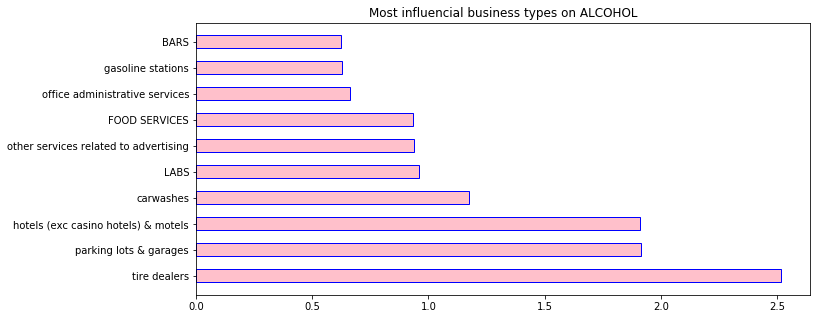

In [49]:
numbers_shown = 10

plt.figure(figsize=(11,5))

plt.barh(y=[i for i in range(1,numbers_shown+1)],
        height=0.5,
        width=alcohol_near_business['offsetted_count'][:numbers_shown],
        tick_label=alcohol_near_business['ACTIVITY DESC'][:numbers_shown],
        color='pink',
        edgecolor='blue')

plt.title('Most influential business types on ALCOHOL');

# 5. Drug Related Stops
### Obtaining all police stops related to drugs

In [52]:
drug_df = reasonable_df[reasonable_df['crime_type'] == '*drugs*']
# this block may take 3 min
business1 = []
business2 = []
business3 = []
distance1 = []
distance2 = []
distance3 = []

tmp = 0
for row in drug_df.itertuples():
    target = closest_3_business(row[2], row[3])
    insert_adapter(business1, business2, business3, distance1, distance2, distance3, target)

In [53]:
drug_business_total = pd.DataFrame()
drug_business_total['ACTIVITY DESC'] = pd.Series(business1 + business2 + business3).value_counts().index
drug_business_total['counts'] = pd.Series(business1 + business2 + business3).value_counts().tolist()
drug_business_total[:5]

,ACTIVITY DESC,counts
0,RETAILERS,574
1,FOOD SERVICES,376
2,PROPERTY SERVICES,300
3,AUTOMOTIVE,240
4,SCIENCE,215


In [54]:
li = []
for row in drug_business_total.itertuples():
    busi_type = row[1]
    near_count = row[2]
    busi_amount = busi_value_counts[busi_value_counts['ACTIVITY DESC'] == busi_type].iloc[0,1]
    li.append(near_count/busi_amount)
drug_business_total['offsetted_count'] = li
drug_business_total.sort_values(by='offsetted_count', inplace=True, ascending=False)
drug_business_total = drug_business_total[drug_business_total['counts']>20]
drug_business_total[:10]

,ACTIVITY DESC,counts,offsetted_count
41,other services related to advertising,29,0.906250
40,parking lots & garages,30,0.517241
36,gasoline stations,32,0.516129
13,BARS,118,0.405498
7,NON-PROFIT,174,0.318681
43,personal care services,28,0.318182
17,limited-service eating places,84,0.304348
34,FURNITURE,34,0.293103
1,FOOD SERVICES,376,0.278725
48,TRAVEL,25,0.265957


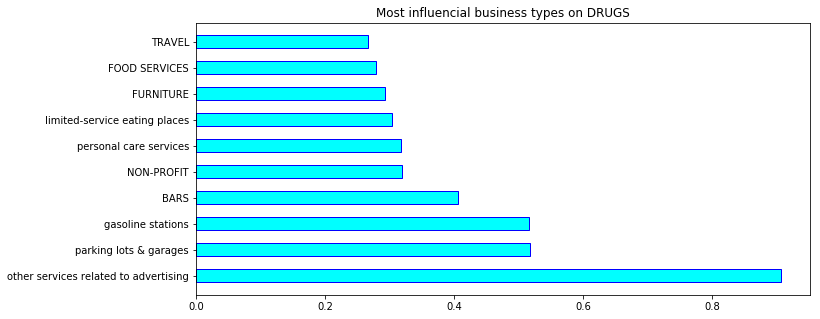

In [55]:
numbers_shown = 10

plt.figure(figsize=(11,5))

plt.barh(y=[i for i in range(1,numbers_shown+1)],
        height=0.5,
        width=drug_business_total['offsetted_count'][:numbers_shown],
        tick_label=drug_business_total['ACTIVITY DESC'][:numbers_shown],
        color='cyan',
        edgecolor='blue');

plt.title('Most influential business types on DRUGS');

# 6. Fight/Battery Related Stops
### Obtaining all police stops related to physical altercations

In [56]:
fight_df = reasonable_df[reasonable_df['crime_type'] == '*fight / battery*']
# this block may take 3 min
business1 = []
business2 = []
business3 = []
distance1 = []
distance2 = []
distance3 = []

tmp = 0
for row in fight_df.itertuples():
    target = closest_3_business(row[2], row[3])
    insert_adapter(business1, business2, business3, distance1, distance2, distance3, target)

In [156]:
fight_business_total = pd.DataFrame()
fight_business_total['ACTIVITY DESC'] = pd.Series(business1 + business2 + business3).value_counts().index
fight_business_total['counts'] = pd.Series(business1 + business2 + business3).value_counts().tolist()
fight_business_total[:5]

,ACTIVITY DESC,counts
0,RETAILERS,643
1,FOOD SERVICES,640
2,PROPERTY SERVICES,363
3,janitorial services,316
4,SCIENCE,256


In [59]:
li = []
for row in fight_business_total.itertuples():
    busi_type = row[1]
    near_count = row[2]
    busi_amount = busi_value_counts[busi_value_counts['ACTIVITY DESC'] == busi_type].iloc[0,1]
    li.append(near_count/busi_amount)
fight_business_total['offsetted_count'] = li
fight_business_total.sort_values(by='offsetted_count', inplace=True, ascending=False)
fight_business_total = fight_business_total[fight_business_total['counts']>20]
fight_business_total[:10]

,ACTIVITY DESC,counts,offsetted_count
50,hotels (exc casino hotels) & motels,33,3.000000
33,gasoline stations,50,0.806452
57,pedi-cab (individual),25,0.735294
39,parking lots & garages,39,0.672414
1,FOOD SERVICES,640,0.474426
15,BARS,122,0.419244
42,personal care services,35,0.397727
26,"hair, nail & skin care services",60,0.344828
21,CLOTHING,91,0.333333
65,administrative & support services,21,0.323077


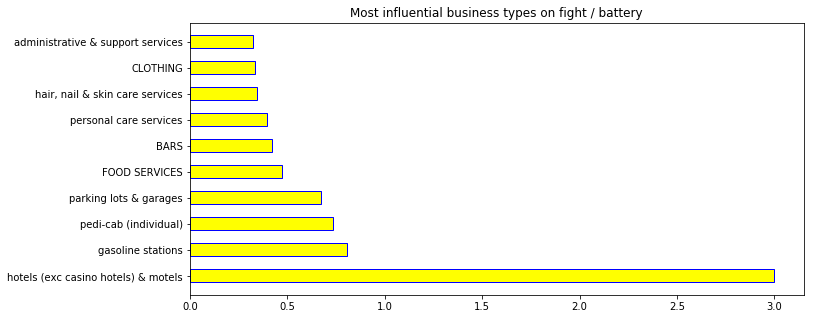

In [60]:
numbers_shown = 10

plt.figure(figsize=(11,5))

plt.barh(y=[i for i in range(1,numbers_shown+1)],
        height=0.5,
        width=fight_business_total['offsetted_count'][:numbers_shown],
        tick_label=fight_business_total['ACTIVITY DESC'][:numbers_shown],
        color='yellow',
        edgecolor='blue');

plt.title('Most influential business types on fight / battery');

One approch we used is assume bussiness have a gravity like force that couses crime to happen around them. We than tried to find the magnatiud of this force for each business type.

We started by transforming each distance to its inverse squred

In [41]:
maxDistance = 20 #km
floor_df = maxDistance / business_df

floor_df = np.floor(floor_df)
floor_df = floor_df / floor_df
floor_df

,fight,fight,alcoh,fight,alcoh,fight,alcoh,fight,fight,fight,...,fight,alcoh,alcoh,fight,alcoh,fight,fight,fight,alcoh,fight
ACTIVITY_DESC,,,,,,,,,,,,,,,,,,,,,
REAL ESTATE,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
ALL OTHER TRANSIT & GROUND PASSENGER TRANS,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
CONSULTING SERVICES,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN
PHOTOGRAPHIC SERVICES,1.0,1.0,1.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,...,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN
OTHER SPECIAL TRADE CONTRACTORS,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,NaN,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,1.0,NaN
FULL-SERVICE RESTAURANTS,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
OTHER PERSONAL SERVICES,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN
GRAPHIC DESIGN SERVICES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MARKETING CONSULTING SERVICES,1.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [199]:

fight_df = floor_df.filter(like='fight')
alcoh_df = floor_df.filter(like='alcoh')


In [200]:
fight_df["number_of_crimes_in_area"] = fight_df.sum(axis=1)
alcoh_df["number_of_crimes_in_area"] = alcoh_df.sum(axis=1)

C:\Users\Tamuz\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Tamuz\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [201]:
alcoh_df = alcoh_df[["number_of_crimes_in_area"]]
fight_df = fight_df[["number_of_crimes_in_area"]]

In [202]:
fight_df = fight_df.reset_index()
alcoh_df = alcoh_df.reset_index()


In [203]:
fight_results = ols('number_of_crimes_in_area ~ C(ACTIVITY_DESC)', data=fight_df).fit()
alcoh_results = ols('number_of_crimes_in_area ~ C(ACTIVITY_DESC)', data=alcoh_df).fit()


In [204]:
fight_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     number_of_crimes_in_area   R-squared:                       0.078
Model:                                  OLS   Adj. R-squared:                  0.074
Method:                       Least Squares   F-statistic:                     21.83
Date:                      Wed, 12 Jun 2019   Prob (F-statistic):               0.00
Time:                              22:17:52   Log-Likelihood:            -1.0381e+05
No. Observations:                     26058   AIC:                         2.078e+05
Df Residuals:                         25957   BIC:                         2.087e+05
Df Model:                               100                                         
Covariance Type:                  nonrobust                                         
=====================================================================================================================================
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                          1004.4865     20.050     50.100      0.000     965.188    1043.785
C(ACTIVITY_DESC)[T.ACTIVITIES RELATED TO REAL ESTATE]               -69.9694     35.314     -1.981      0.048    -139.187      -0.752
C(ACTIVITY_DESC)[T.ADVERTISING & RELATED SERVICES]                   55.9528     42.332      1.322      0.186     -27.021     138.927
C(ACTIVITY_DESC)[T.ALL OTH PROF, SCIENTIFIC & TECHNICAL SERVICES]   -25.9950     23.287     -1.116      0.264     -71.640      19.650
C(ACTIVITY_DESC)[T.ALL OTHER AUTOMOTIVE R&M]                         45.9289     39.321      1.168      0.243     -31.141     122.999
C(ACTIVITY_DESC)[T.ALL OTHER GENERAL MERCHANDISE STORES]              6.3966     36.984      0.173      0.863     -66.094      78.887
C(ACTIVITY_DESC)[T.ALL OTHER MISCELLANEOUS STORE RETAILERS]          37.5607     42.487      0.884      0.377     -45.716     120.838
C(ACTIVITY_DESC)[T.ALL OTHER PERSONAL SERVICES]                      -9.7106     24.340     -0.399      0.690     -57.418      37.997
C(ACTIVITY_DESC)[T.ALL OTHER SPECIAL TRADE CONTRACTORS]            -468.4162     25.884    -18.097      0.000    -519.150    -417.682
C(ACTIVITY_DESC)[T.ALL OTHER TRANSIT & GROUND PASSENGER TRANS]      -50.5512     38.367     -1.318      0.188    -125.753      24.650
C(ACTIVITY_DESC)[T.ARCHITECTURAL SERVICES]                          -52.1335     43.130     -1.209      0.227    -136.670      32.403
C(ACTIVITY_DESC)[T.ARCHITECTURAL, ENGINEERING & RELATED SERVICES]   -51.2786     35.179     -1.458      0.145    -120.232      17.675
C(ACTIVITY_DESC)[T.AUTOMOTIVE R&M]                                   62.7186     36.816      1.704      0.088      -9.443     134.880
C(ACTIVITY_DESC)[T.BARBER SHOPS]                                     85.3193     42.965      1.986      0.047       1.105     169.534
C(ACTIVITY_DESC)[T.BEAUTY SALONS]                                    70.6448     25.358      2.786      0.005      20.941     120.349
C(ACTIVITY_DESC)[T.BEAUTY SHOPS - BOOTH RENTAL]                      46.9720     28.778      1.632      0.103      -9.434     103.378
C(ACTIVITY_DESC)[T.BEER, WINE & LIQUOR STORES]                      103.7782     43.130      2.406      0.016      19.242     188.315
C(ACTIVITY_DESC)[T.BUILDING, DEVELOPING & GENERAL CONTRACTING]     -330.0018     24.869    -13.269      0.000    -378.747    -281.256
C(ACTIVITY_DESC)[T.BUSINESS TAX EXEMPT]                              32.9656     34.542      0.954      0.340     -34.738     100.669
C(ACTIVITY_DESC)[T.BUSINESS TAX EXEMPT - NON PROFIT]                 

In [205]:
alcoh_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     number_of_crimes_in_area   R-squared:                       0.061
Model:                                  OLS   Adj. R-squared:                  0.058
Method:                       Least Squares   F-statistic:                     16.97
Date:                      Wed, 12 Jun 2019   Prob (F-statistic):          2.92e-278
Time:                              22:17:52   Log-Likelihood:            -1.0636e+05
No. Observations:                     26058   AIC:                         2.129e+05
Df Residuals:                         25957   BIC:                         2.137e+05
Df Model:                               100                                         
Covariance Type:                  nonrobust                                         
=====================================================================================================================================
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                             8.8568      0.747     11.861      0.000       7.393      10.320
C(ACTIVITY_DESC)[T.ACTIVITIES RELATED TO REAL ESTATE]                 2.3251      1.315      1.768      0.077      -0.253       4.903
C(ACTIVITY_DESC)[T.ADVERTISING & RELATED SERVICES]                    1.8255      1.577      1.158      0.247      -1.265       4.916
C(ACTIVITY_DESC)[T.ALL OTH PROF, SCIENTIFIC & TECHNICAL SERVICES]    -1.8898      0.867     -2.179      0.029      -3.590      -0.190
C(ACTIVITY_DESC)[T.ALL OTHER AUTOMOTIVE R&M]                          3.0279      1.464      2.068      0.039       0.157       5.898
C(ACTIVITY_DESC)[T.ALL OTHER GENERAL MERCHANDISE STORES]              0.8445      1.377      0.613      0.540      -1.855       3.544
C(ACTIVITY_DESC)[T.ALL OTHER MISCELLANEOUS STORE RETAILERS]           2.7565      1.582      1.742      0.082      -0.345       5.858
C(ACTIVITY_DESC)[T.ALL OTHER PERSONAL SERVICES]                       0.3686      0.907      0.407      0.684      -1.408       2.145
C(ACTIVITY_DESC)[T.ALL OTHER SPECIAL TRADE CONTRACTORS]              -6.6351      0.964     -6.883      0.000      -8.525      -4.746
C(ACTIVITY_DESC)[T.ALL OTHER TRANSIT & GROUND PASSENGER TRANS]       -1.7416      1.429     -1.219      0.223      -4.542       1.059
C(ACTIVITY_DESC)[T.ARCHITECTURAL SERVICES]                            2.0942      1.606      1.304      0.192      -1.054       5.243
C(ACTIVITY_DESC)[T.ARCHITECTURAL, ENGINEERING & RELATED SERVICES]     0.5927      1.310      0.452      0.651      -1.975       3.161
C(ACTIVITY_DESC)[T.AUTOMOTIVE R&M]                                    2.5086      1.371      1.830      0.067      -0.179       5.196
C(ACTIVITY_DESC)[T.BARBER SHOPS]                                      8.0559      1.600      5.034      0.000       4.919      11.192
C(ACTIVITY_DESC)[T.BEAUTY SALONS]                                     6.2000      0.944      6.565      0.000       4.349       8.051
C(ACTIVITY_DESC)[T.BEAUTY SHOPS - BOOTH RENTAL]                       6.2951      1.072      5.873      0.000       4.194       8.396
C(ACTIVITY_DESC)[T.BEER, WINE & LIQUOR STORES]                        3.7903      1.606      2.360      0.018       0.642       6.939
C(ACTIVITY_DESC)[T.BUILDING, DEVELOPING & GENERAL CONTRACTING]       -5.2076      0.926     -5.622      0.000      -7.023      -3.392
C(ACTIVITY_DESC)[T.BUSINESS TAX EXEMPT]                               1.3135      1.286      1.021      0.307      -1.208       3.835
C(ACTIVITY_DESC)[T.BUSINESS TAX EXEMPT - NON PROFIT]                 

In [206]:
aov_table_fight = sm.stats.anova_lm(fight_results, typ=2)
aov_table_alc = sm.stats.anova_lm(alcoh_results, typ=2)

In [207]:
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    
    cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov



In [208]:
print("Alcohol:")
anova_table(aov_table_alc)


Alcohol:


,sum_sq,df,mean_sq,F,PR(>F),eta_sq,omega_sq
C(ACTIVITY_DESC),3.501397e+05,100.0,3501.397174,16.971013,2.922617e-278,0.061369,0.057751
Residual,5.355353e+06,25957.0,206.316332,NaN,NaN,NaN,NaN


In [209]:
alcoh_results.diagn

{'jb': 213727.0469142914,
 'jbpv': 0.0,
 'skew': 3.115849532801785,
 'kurtosis': 15.570334542599655,
 'omni': 17292.920151769322,
 'omnipv': 0.0,
 'condno': 85.845187781427313,
 'mineigval': 3.590527344524991}

In [210]:
print("Fight:")
anova_table(aov_table_alc)


Fight:


sum_sq       df      mean_sq          F  \
C(ACTIVITY_DESC)  3.501397e+05    100.0  3501.397174  16.971013   
Residual          5.355353e+06  25957.0   206.316332        NaN   

                         PR(>F)    eta_sq  omega_sq  
C(ACTIVITY_DESC)  2.922617e-278  0.061369  0.057751  
Residual                    NaN       NaN       NaN

In [211]:
fight_results.diagn

{'jb': 101953.09894359244,
 'jbpv': 0.0,
 'skew': 2.533138813384164,
 'kurtosis': 11.260382087819854,
 'omni': 13970.625441403527,
 'omnipv': 0.0,
 'condno': 85.845187781427313,
 'mineigval': 3.590527344524991}

In [212]:
#Since our data failed the assumption of homogeneity of variance (omni) we used heteroscedasticity corrected 
#coefficient covariance matrix to account for it

In [213]:
alc_table = sm.stats.anova_lm(fight_results, typ=1)
alc_table

In [214]:
# Seeing which Business type 

In [215]:
fight_df = fight_df.sort_values("ACTIVITY_DESC")

In [225]:
plt.figure(dpi=1200)

for i in 

#fight_df.iloc[0:int(len(fight_df)/n)].boxplot('number_of_crimes_in_area', by='ACTIVITY_DESC', figsize=(16, 10), fontsize=10, rot=50)
fight_df["ACTIVITY_DESC"].unique()

array(['ACCOUNTING/TAX PREP/BOOKKEEP/PAYROLL SERVICES',
       'ACTIVITIES RELATED TO REAL ESTATE',
       'ADVERTISING & RELATED SERVICES',
       'ALL OTH PROF, SCIENTIFIC & TECHNICAL SERVICES',
       'ALL OTHER AUTOMOTIVE R&M', 'ALL OTHER GENERAL MERCHANDISE STORES',
       'ALL OTHER MISCELLANEOUS STORE RETAILERS',
       'ALL OTHER PERSONAL SERVICES',
       'ALL OTHER SPECIAL TRADE CONTRACTORS',
       'ALL OTHER TRANSIT & GROUND PASSENGER TRANS',
       'ARCHITECTURAL SERVICES',
       'ARCHITECTURAL, ENGINEERING & RELATED SERVICES', 'AUTOMOTIVE R&M',
       'BARBER SHOPS', 'BEAUTY SALONS', 'BEAUTY SHOPS - BOOTH RENTAL',
       'BEER, WINE & LIQUOR STORES',
       'BUILDING, DEVELOPING & GENERAL CONTRACTING', 'BUSINESS TAX EXEMPT',
       'BUSINESS TAX EXEMPT - NON PROFIT', 'CHILD DAY CARE SERVICES',
       'CIVIC & SOCIAL ORGANIZATIONS',
       'COMPUTER SYSTEMS DESIGN & RELATED SERVICES', 'CONSTRUCTION',
       'CONSULTING SERVICES', 'DIRECT SELLING ESTABLISHMENTS',
       'E

<Figure size 7200x4800 with 0 Axes>

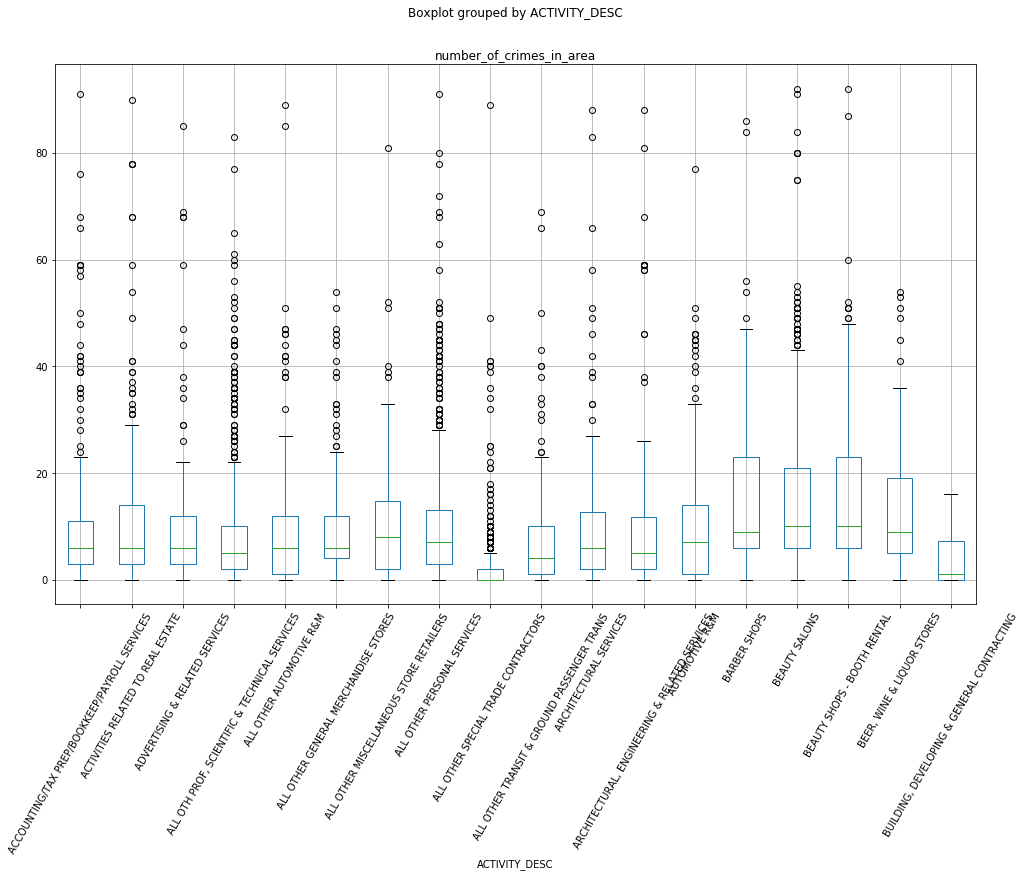

In [227]:

fight_df.iloc[0:int(len(fight_df)/5)].boxplot('number_of_crimes_in_area', by='ACTIVITY_DESC', figsize=(16, 10), fontsize=10, rot=60)

# Ethics & Privacy

The dataset was acquired from The San Diego Open Data Portal (SDODP), which is a public database for anyone to use. We did not have to deal with any privacy concern regarding the dataset acquired from SDODP since the data was already anonymized. Nevertheless, we still verified whether the datasets were completely free of sensitive information that could lead to privacy concerns by following the guidelines in the official documentation from the Safe Harbour Method.

The data collected was entered by the San Diego Police Department after conducting a police stop. Therefore, it is probable that the data is directly influenced by the biases inherent of the San Diego Police Department such as what neighborhoods police officers choose to patrol more than others. The analysis conducted must be understood in this context and not be generalized to make claims that are not backed up by the data.

The most important issue we had is the possible confusion of police stops and crimes. Police stops had several inherent biases such as the location police officers choose to patrol and who they choose to stop. Furthermore, the frequency of police stops in an area does not reveal an inherent correlation to crimes in that area. We ensured that this distinction was made clear as to not create unfounded or biased conclusions. 




# Conclusion & Discussion

In our expoloratory analysis we found that there were certain business types that had a significantly larger number of police stops related to alcohol, drugs, and physical altercations. These business types include hotels/motels and parking lots/garages. Although this analysis did not completely support our background research, we still found that bars and other alcohol related business did have some signficance to the type of police stops we were investigating, albiet a smaller significance compared to other business types.

Based on our ANOVA analysis and modeling however, we found that our hypothesis was proven to be true. 
As seen in our ANOVA summaries above the F statistics is significantly greater our F critical value which is close to 0. This means that the probability of certain business types based on the average number of police stops in the area is statistically signficant. In other words, the chance of randomly obtaining a distribution that is the same as our dataset is close to zero. By this fact, we are able to reject the null hypothesis and say that there exists a correlation between the type of business and police stops related with intoxicating substances (drugs and alcohol) and physical altercations.

Due to the nature of the methods we used in our analysis, there were some assumptions that we made in order to come to a conclusion. Some assumptions were used in order to consolidate the business types into certain categories and the removal of certain business types due to the small number of them in San Diego. Because of this, we may have missed some correlations that may have affected our results. Additionally, although our result was statistically significant, due to 